<a href="https://colab.research.google.com/github/leonhardrobin/fh-ai-24/blob/main/AI_WS2425_Exercise_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this exercise, we will look at classifying the CIFAR10-dataset (i.e., the same images as discussed in the lecture). You can find the individual tasks in the code examples below.

You should solve the following tasks:
1) randomly show 5 images from the dataset
2) randomly show 5 images based on the matrices generated from the dataset
3) calculate and apply the average loss and accuracy metrics
4) Hyperparameter evaluation: run the model with 3x3 learning rates (0.01, 0.001, 0.0001) and epochs (20, 50, 100) and note the results (i.e., final accuracies of all sets). Make a plot of the best performing hyperparameter configuration (i.e., accuracy (y) over epochs (x))
5) Interpret the results of your models, i.e., why are they performing good/bad?

1) Import the necessary libraries

In [1]:
import torch
from pathlib import Path
import pandas as pd
import io
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import random as rand



2) Load the CIFAR10 dataset, which is part of pytorch

In [2]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True)
# the labels will be put in a seperate vector as the original is just numbers, but we want text labels
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:15<00:00, 11159180.72it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Now, lets look into some of the images...

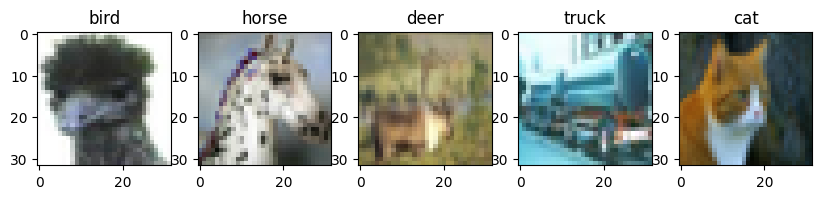

In [3]:
example = 3465
image, label = trainset[example] #since each element of the trainset list is itself a tuple with the image details, and then the label
#print("this is an image of a " + classes[(trainset[example])[1]]) # first index into tuple in trainset, then the 2nd value (label), and then the classes
#plt.imshow(image)

# TASK 1: randomly show 5 images from the trainingset, i.e., the random number generator should draw a value between 0 and the size of the set
fig = plt.figure(figsize=(10, 50))

for i in range(5):
  randomIndex = rand.randint(0, len(trainset))
  image, label = trainset[randomIndex]
  fig.add_subplot(1,5,i+1, title=classes[(trainset[randomIndex])[1]])
  plt.imshow(image)

We utilize the pytorch transform module to create matrices of color values from the images...

In [4]:
datasetT = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transforms.ToTensor())

Files already downloaded and verified


Now we have matrices with the dimensions 3x32x32 (i.e., 32*32 pixels and 3 RGB colors). We can assess one of the training examples with the following code

size of image matrix: torch.Size([3, 32, 32])
this is an image of a dog


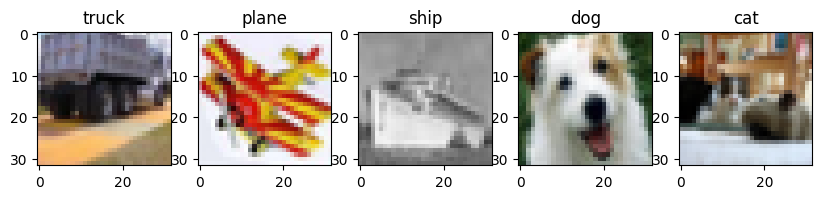

In [5]:
example = 128
imgTensor, label = datasetT[example]
print('size of image matrix: ' + str(imgTensor.shape))
print("this is an image of a " + classes[(trainset[example])[1]])

#TASK 2: similar as above, use matplotlib to visualze 5 images randomly drawn from the dataset (but use the matrices now!)
#you should create a numpy array from the tensor, flip dimensions/axis accordingly, and plot

fig = plt.figure(figsize=(10, 50))

for i in range(5):
  randomIndex = rand.randint(0, len(datasetT))
  imgTensor, label = datasetT[randomIndex]
  imgTensor = imgTensor.numpy()
  imgTensor = np.swapaxes(imgTensor, 0, 2)
  imgTensor = np.swapaxes(imgTensor, 0, 1)
  fig.add_subplot(1,5,i+1, title=classes[(trainset[randomIndex])[1]])
  plt.imshow(imgTensor)

next, we build a training set (60%), a cross-validation set (20%), and a test set fo the final validation (20%)

In [6]:
#length of training examples.
m = 50000

#percentage of m dedicated to CV.
pCV = 0.2

# give the amount of examples dedicated to CV.
mCV = int(m*pCV)
print("amount of training examples: " + str(m - mCV))
print("amount of cross validation examples: " + str(mCV))

amount of training examples: 40000
amount of cross validation examples: 10000


Next, we shuffle the data and create the sets...

In [7]:
def ShuffleAndSPlit(countExamples, percentageCV):
  """ randomly shuffle a training set's indices, then split the indices into training and cross validation sets.
   Pass in 'm', length of training set, and 'pCV', the percentage of the training set you would like
   to dedicate to cross validation."""

  # determine size of CV set.
  mCV = int(countExamples*percentageCV)

  #create random permutation of 0 to m-1 - randomly shuffle all values from 0 to m.
  indices = np.random.permutation(countExamples)

  #pick first mCV indices for training, and then validation.
  return indices[mCV:], indices[:mCV]

trainIndices, valIndices = ShuffleAndSPlit(m, pCV)

Now, we load the indices into groups for Stochastic Gradient Descent

In [8]:
#We define a batch size and use the SubsetRandomSampler and the DataLoader as given by pytorch: https://pytorch.org/docs/stable/data.html

batchSize = 100
#First, we create a sampler using our training set
trainSampler = SubsetRandomSampler(trainIndices)
#The dataloader helps us to draw batchSize randomly sampled examples from our training datasetT
trainLoader = DataLoader(datasetT, batchSize, sampler=trainSampler)

#The same happens for the validation set...
valSampler = SubsetRandomSampler(valIndices)
valLoader = DataLoader(datasetT, batchSize, sampler=valSampler)

Now we prepare our model - since the data should be a vector, each 3x32x32 image tensor needs to be flattened to a vector of length 3072

In [9]:
# this will define the rows of the matrix
inputSize = 3*32*32

# this will define the columns of the matrix
numClasses = 10

# create our linear regression model (nn.Linear creates bias vector)
model = nn.Linear(inputSize, numClasses)

print('dimensions of weight matrix W: ' + str(model.weight.shape))
print(model.weight)

print('dimensions of bias matrix b: ' + str(model.bias.shape))
print(model.bias)

dimensions of weight matrix W: torch.Size([10, 3072])
Parameter containing:
tensor([[-0.0093, -0.0050,  0.0150,  ..., -0.0160,  0.0047, -0.0011],
        [ 0.0122,  0.0101,  0.0019,  ..., -0.0058,  0.0079, -0.0057],
        [-0.0021,  0.0141,  0.0147,  ...,  0.0158, -0.0077, -0.0177],
        ...,
        [ 0.0080, -0.0174, -0.0129,  ...,  0.0079,  0.0106,  0.0134],
        [-0.0159, -0.0088,  0.0137,  ...,  0.0111,  0.0127, -0.0118],
        [-0.0165,  0.0082, -0.0152,  ...,  0.0148, -0.0079,  0.0065]],
       requires_grad=True)
dimensions of bias matrix b: torch.Size([10])
Parameter containing:
tensor([ 0.0122, -0.0063, -0.0028,  0.0066, -0.0086,  0.0043, -0.0137,  0.0068,
         0.0006,  0.0135], requires_grad=True)


Now, we take images from one batch of the dataset and put it into the model.

In [11]:
#this class reshapes the matrices to be compatible, i.e., batchsize times 3072 (32x32x3)
#the CIFAR10 class is a subclass of nn.Module, inheriting all its functions
class CIFAR10(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(inputSize, numClasses)

    def forward(self, xb):
        xb = xb.reshape(-1, 3072)
        out = self.linear(xb)
        return out

model = CIFAR10()

In [12]:
print(model.linear.weight.shape)
print(model.linear.bias.shape)

for images, labels in trainLoader:
  outputs = model(images)
  break

print('outputs.shape :', outputs.shape)
print('sample outputs :\n', outputs[:2]) # print 2 out of the 100 rows of the total output vector

torch.Size([10, 3072])
torch.Size([10])
outputs.shape : torch.Size([100, 10])
sample outputs :
 tensor([[-0.0127, -0.2937,  0.0194, -0.4476,  0.2985, -0.2108,  0.1889,  0.2102,
          0.1915,  0.2330],
        [-0.2233, -0.4010,  0.5095, -0.5099,  0.1863, -0.0335,  0.0568,  0.3997,
          0.0162,  0.4383]], grad_fn=<SliceBackward0>)


Stochastic Gradient Descent - Cross Entropy Loss
Pytorch will apply softmax automatically

In [13]:
lossFn = F.cross_entropy

loss = lossFn(outputs, labels)
print(loss)

tensor(2.3087, grad_fn=<NllLossBackward0>)


We train the model using the:

Data loaders
Model
Loss function
Optimizer

This model will use the training set (xb, yb) to train the parameters, and will evaluate the cost function again for the cross validation set.

Let's define a function lossBatch which calculates the loss for some given batch, and performs a gradient update step for ALL the parameters based on that batch if an optimizer is provided. Also, it computes a metric (e.g accuracy) optionally.

In [14]:
learningRate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

# recall that items is a list batchSize long of 3x32x32 images. labels is the corresponding labels vector for those images.

def lossBatch(model, lossFn, items, labels, opt=None, metric=None):
  # calculate the loss of the items given the original labels
  preds = model(items)
  loss = lossFn(preds, labels)

  #Here, the optimization step is performed -
  if opt is not None:
    # compute gradients: https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html
    loss.backward()
    # update parameters: https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.step.html
    opt.step()
    # reset gradients to 0
    opt.zero_grad()

  metricResult = None
  if metric is not None:
    metricResult = metric(preds, labels)

  return loss.item(), len(items),  metricResult

The above code defines a function, when given the

model (linear.nn), the loss function (cross entropy)
items (the images matrices for the given batch)
labels (the corresponding labels for that batch)
and optionally, opt (the optimization algorithm)
metric. It returns the loss for the training set for that batch (loss.item())
the length of the batch (items)
the result of the metric, if given (metricResult)

Next, let's define a function that computes and evaluates the total cost on the validation set.

In [15]:
def evaluate(model, lossFn, validDL, metric=None):

  # pass each batch of the validation set through the model to form a multidimensional list (holding loss, length and metric for each batch)
  results = [lossBatch(model, lossFn, items, labels, metric=metric,) for items,labels in validDL]

  # separate losses, counts and metrics
  losses, nums, metrics = zip(*results)

  # total size of the dataset (we keep track of lengths of batches since dataset might not be perfectly divisible by batch size)
  total = np.sum(nums)

  # find average total loss over all batches in validation (remember these are all vectors doing element wise operations.)
  # Now, we have a list of "losses", their vector lenghts "nums" and the number of total items over all batches

  # TASK3: calculate the average loss over the validation set, as well as the average metrics (see below)
  avgLoss = sum(losses)/total

  # if there is a metric passed, compute the average metric
  if metric is not None:
    # avg of metric accross batches
    avgMetric = np.sum(np.multiply(metrics, nums)) / total

  return avgLoss, total, avgMetric

We also need to redefine our metric, accuracy, to operate on a batch of outputs directly as opposed to just getting predictions and labels.

In [16]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.sum(preds == labels).item() / len(preds)

Accuracy takes in the outputs (batchSize x 10, one output for each class) and labels (1 x batchSize). It then gets the index of the max values for each row of outputs, which is the predicted value for each training example. Then, it sums the boolean matrix created by preds == labels, and divides it by the length of the batch, to get the accuracy of the predictions.

In [17]:
# test the evaluate function on both the training and the validation set
Etrain = evaluate(model, lossFn, trainLoader, metric=accuracy)
Eval = evaluate(model, lossFn, valLoader, metric=accuracy)
print("training set loss: ", Etrain[0])
print("validation set loss: ", Eval[0])

training set loss:  0.02345168136358261
validation set loss:  0.023461851525306703


Finally, the fit function iterates through the number of desired update steps and improves the model

In [18]:
def fit(epochs, model, lossFn, opt, trainDL, valDL, metric=None):
  #valList will hold our accuracies after each epoch (i.e., update step), where we should see an improvement.
  #To start with some "bad" accuracy, we initialize it with 10%
  valList = [0.10]

  for epoch in range(epochs):
    # training - perform one step gradient descent on each batch, then moves on
    # therefore, we use the "lossBatch" function defined above
    for items, labels in trainDL:
      loss,_,lossMetric = lossBatch(model, lossFn, items, labels, opt)

    # evaluation on cross validation dataset - after updating over all batches, technically one epoch
    # evaluates over all validation batches and then calculates average val loss, as well as the metric (accuracy)
    valResult = evaluate(model, lossFn, valDL, metric)
    valLoss, total, valMetric = valResult
    valList.append(valMetric)
    # print progress
    if metric is None:
      print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, epochs, valLoss))
    else:
      print('Epoch [{}/{}], Loss: {:.4f}, {}: {:.4f}'.format(epoch + 1, epochs, valLoss, metric.__name__, valMetric))

  return valList

now, we can finally train the model using Stochastic Gradient Descent

In [20]:
#TASK4: Hyperparameter evaluation: run the model with 3x3 learning rates (0.01, 0.001, 0.0001)
# and epochs (20, 50, 100) and note the results (i.e., final accuracies of all sets).
# Make a plot of the best performing hyperparameter configuration (i.e., accuracy (y) over epochs (x))

learningRates = [0.01, 0.001, 0.0001]
epochs = [20, 50, 100]
results = []

for learningRate in learningRates:
  for epoch in epochs:
    model = CIFAR10()
    optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
    trainList = fit(epoch, model, lossFn, optimizer, trainLoader, valLoader, metric=accuracy)
    results.append((trainList, learningRate, epoch, model))
    print("")
    print("learning rate: " + str(learningRate))
    print("epochs: " + str(epoch))
    print("final accuracy: " + str(trainList[-1]))
    print("--------------------------------------------------------------")





#model = CIFAR10()
# we use SDG https://pytorch.org/docs/stable/generated/torch.optim.SGD.html
#optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

# we call the fit function, with the desired number of epochs, the model, the loss function,
# the just before defined optimizer, the datasets, and the accuracy metric
#trainList = fit(epochs, model, lossFn, optimizer, trainLoader, valLoader, metric=accuracy)



Epoch [1/20], Loss: 0.0190, accuracy: 0.3261
Epoch [2/20], Loss: 0.0185, accuracy: 0.3444
Epoch [3/20], Loss: 0.0184, accuracy: 0.3553
Epoch [4/20], Loss: 0.0183, accuracy: 0.3538
Epoch [5/20], Loss: 0.0180, accuracy: 0.3656
Epoch [6/20], Loss: 0.0179, accuracy: 0.3742
Epoch [7/20], Loss: 0.0181, accuracy: 0.3629
Epoch [8/20], Loss: 0.0179, accuracy: 0.3704
Epoch [9/20], Loss: 0.0177, accuracy: 0.3891
Epoch [10/20], Loss: 0.0177, accuracy: 0.3930
Epoch [11/20], Loss: 0.0176, accuracy: 0.3898
Epoch [12/20], Loss: 0.0176, accuracy: 0.3863
Epoch [13/20], Loss: 0.0177, accuracy: 0.3937
Epoch [14/20], Loss: 0.0178, accuracy: 0.3705
Epoch [15/20], Loss: 0.0176, accuracy: 0.3922
Epoch [16/20], Loss: 0.0175, accuracy: 0.3980
Epoch [17/20], Loss: 0.0176, accuracy: 0.3877
Epoch [18/20], Loss: 0.0175, accuracy: 0.3921
Epoch [19/20], Loss: 0.0176, accuracy: 0.3876
Epoch [20/20], Loss: 0.0175, accuracy: 0.3923

learning rate: 0.01
epochs: 20
final accuracy: 0.3923
----------------------------------

now, we look at the accuracies of the sets

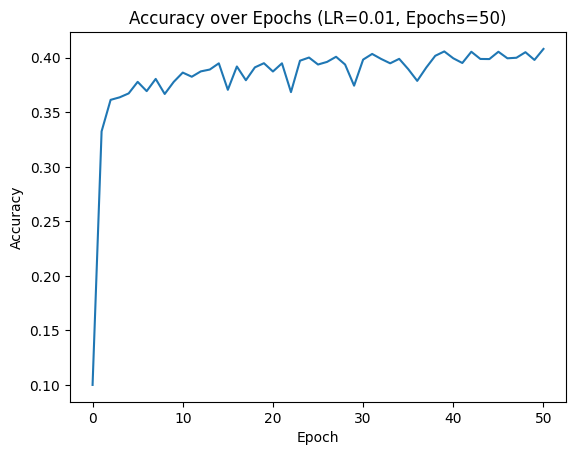

In [25]:
best_trainList = max(results, key=lambda item: item[0][-1])
best_accuracy_list, best_learning_rate, best_epoch, _ = best_trainList

plt.plot(range(len(best_accuracy_list)), best_accuracy_list)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy over Epochs (LR={best_learning_rate}, Epochs={best_epoch})')
plt.show()

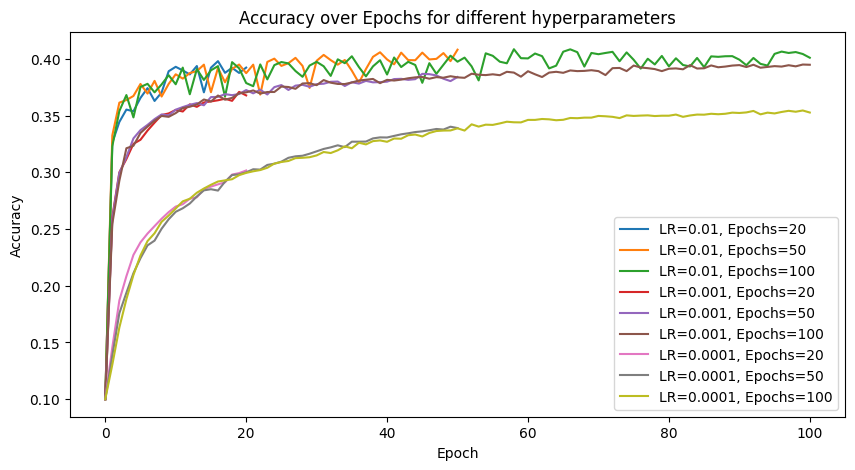

In [26]:
plt.figure(figsize=(10, 5))
for trainList, learningRate, epoch, _ in results:
  plt.plot(range(len(trainList)), trainList, label=f'LR={learningRate}, Epochs={epoch}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs for different hyperparameters')
plt.legend()
plt.show()

In [28]:
test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())


Files already downloaded and verified


In [29]:
testLoader = DataLoader(test, batchSize)

# Interpretation

All of the models are doing a very bad job. The best one is the one trained with a learning rate of 0.01 and with 50 epochs with an accuracy for the cross-validation of 40.81%.
However, beginning with epoch 39, the accuracy and loss started to level out and go up and down. The same can be seen with a learing rate of 0.01 but with 100 epochs.

The lower learning rate seems to make to little of a change to keep minimizing the loss and ultimately the accuracy.
But the overall bad performance can most likely be attibuted to the simplicity of the model itself.

A single linear classifier cannot handle differantiating 10 classes of animals in a picture.



In [36]:
#TASK5 Interpret the results of your models, i.e., why are they performing good/bad?
for _, lr, epoch, curModel in results:
    print("LR: " + str(lr) + " Epochs: " + str(epoch))
    avgLoss, total, avgMetric = evaluate(curModel, F.cross_entropy, testLoader, metric=accuracy)
    print("test set accuracy: \n", avgMetric)
    avgLoss, total, avgMetric = evaluate(curModel, F.cross_entropy, valLoader, metric=accuracy)
    print("cross validation set accuracy: \n",avgMetric)
    avgLoss, total, avgMetric = evaluate(curModel, F.cross_entropy, trainLoader, metric=accuracy)
    print("training set accuracy: \n",avgMetric)
    print("________________________________________________")

LR: 0.01 Epochs: 20
test set accuracy: 
 0.3944
cross validation set accuracy: 
 0.3923
training set accuracy: 
 0.413375
________________________________________________
LR: 0.01 Epochs: 50
test set accuracy: 
 0.4018
cross validation set accuracy: 
 0.4081
training set accuracy: 
 0.438225
________________________________________________
LR: 0.01 Epochs: 100
test set accuracy: 
 0.4028
cross validation set accuracy: 
 0.401
training set accuracy: 
 0.447775
________________________________________________
LR: 0.001 Epochs: 20
test set accuracy: 
 0.3702
cross validation set accuracy: 
 0.3678
training set accuracy: 
 0.377125
________________________________________________
LR: 0.001 Epochs: 50
test set accuracy: 
 0.3877
cross validation set accuracy: 
 0.384
training set accuracy: 
 0.39665
________________________________________________
LR: 0.001 Epochs: 100
test set accuracy: 
 0.3942
cross validation set accuracy: 
 0.3948
training set accuracy: 
 0.41255
______________________